In [1]:
from jpeg_implementation.dct import block_dct2, block_idct2
from jpeg_implementation.huffman import generate_huffman_code, encode_huffman, decode_huffman
from jpeg_implementation.quantization import quantize, quantize_inverse, \
    get_quantization_matrix_for_quality_percent
from jpeg_implementation.runLengthEncode import  resort_values_zig_zag, run_length_encode, flatten, resort_values_zig_zag_reverse, run_length_decode, un_flatten

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

In [2]:
# image which should be encoded
image_path = "images/lenna_32x32.png"

# jpeg parameters
block_size: int = 8
subsampling_settings: Tuple[int, int, int] = (4, 2, 0)  # can be (4,1,0), (4,1,1), (4,2,0), (4,2,2), (4,4,4)
quantization_table_quality: int = 70  # percentage of quantization quality 0..100

[[158 156 165 147  98 106 110 124]
 [157 159 164 144  95 105 108 122]
 [161 163 161 142  94 104 108 121]
 [165 139 161 145  90 101 108 121]
 [152 106 164 142  85 100 105 116]
 [109 105 164 141  87 100 105 117]
 [ 91 105 162 142  86  99 104 116]
 [ 91 103 161 142  83  98 104 122]]


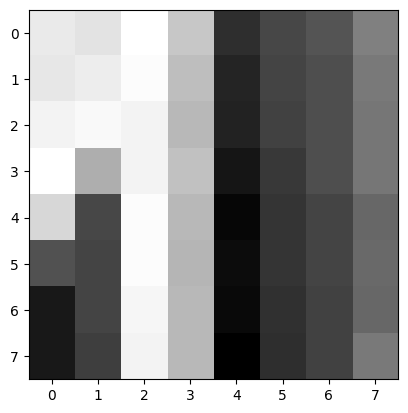

In [3]:
original_image = plt.imread(image_path)

# strip alpha channel if exists
if original_image.shape[2] == 4:
    channels = np.dsplit(original_image, 4)
    original_image = np.dstack(channels[:3])

# select only 8x8 matrix
original_image = original_image[:8, :8]
# convert to grayscale
original_image = np.dot(original_image[...,:3], [0.299, 0.587, 0.114])

# convert range from 0..1 to int (0..255)
original_image *= 255
original_image = np.rint(original_image)
original_image = original_image.astype(int)

fig, ax = plt.subplots()
ax.imshow(original_image, cmap="gray")
print(np.matrix(original_image))

## Step 4
### Apply dct

In [4]:
trans = block_dct2(original_image - 128, block_size)

data after dct:
 [[ 22.716  29.113  26.342  11.589 -44.815 -28.815  -9.226   4.734]
 [ 20.53   30.835  25.829   7.534 -48.093 -29.547 -10.505   3.943]
 [ 22.656  35.618  23.6     3.84  -48.818 -30.466 -10.235   3.203]
 [ 31.889  16.015  14.804  11.468 -52.689 -31.663  -8.349   4.183]
 [ 28.108 -18.873   8.607  16.374 -58.148 -29.66  -10.229   2.02 ]
 [-11.483 -33.224  15.697  17.038 -53.131 -27.986  -8.906   3.49 ]
 [-28.961 -38.285  16.25   17.834 -52.622 -28.813  -8.845   3.296]
 [-28.803 -39.434  14.458  18.613 -54.557 -27.923  -6.082   9.098]]


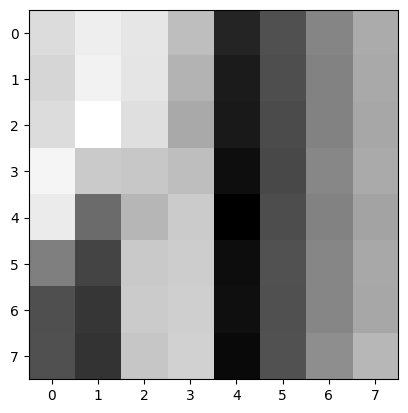

In [5]:
print("data after dct:\n", np.round(trans,3))
fig, ax = plt.subplots()
ax.imshow(trans, cmap="gray")
plt.show()

## Step 5
### Quantization


In [6]:
quantization_table = get_quantization_matrix_for_quality_percent(quantization_table_quality)

quantized = quantize([trans], quantization_table)

quantization_table (quality: 70%): 
 [[10.  7.  6. 10. 14. 24. 31. 37.]
 [ 7.  7.  8. 11. 16. 35. 36. 33.]
 [ 8.  8. 10. 14. 24. 34. 41. 34.]
 [ 8. 10. 13. 17. 31. 52. 48. 37.]
 [11. 13. 22. 34. 41. 65. 62. 46.]
 [14. 21. 33. 38. 49. 62. 68. 55.]
 [29. 38. 47. 52. 62. 73. 72. 61.]
 [43. 55. 57. 59. 67. 60. 62. 59.]]
data after quantization:
 [[ 2.  4.  4.  1. -3. -1. -0.  0.]
 [ 3.  4.  3.  1. -3. -1. -0.  0.]
 [ 3.  4.  2.  0. -2. -1. -0.  0.]
 [ 4.  2.  1.  1. -2. -1. -0.  0.]
 [ 3. -1.  0.  0. -1. -0. -0.  0.]
 [-1. -2.  0.  0. -1. -0. -0.  0.]
 [-1. -1.  0.  0. -1. -0. -0.  0.]
 [-1. -1.  0.  0. -1. -0. -0.  0.]]


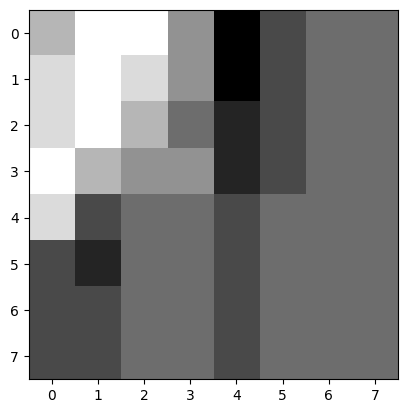

In [7]:
print(f"quantization_table (quality: {quantization_table_quality}%): \n", quantization_table)
print("data after quantization:\n", quantized[0])
fig, ax = plt.subplots()
ax.imshow(quantized[0], cmap="gray")
plt.show()

## Step 6
### Reordering of values, Run Length Encoding

In [8]:
resorted = resort_values_zig_zag(quantized, block_size)
encoded_blocks = run_length_encode(resorted)
rl_encoded = flatten(encoded_blocks)

print(encoded_blocks)
print(rl_encoded)

[(2.0, 1), (4.0, 1), (3.0, 2), (4.0, 2), (1.0, 1), (3.0, 1), (4.0, 2), (3.0, 1), (2.0, 2), (1.0, 1), (-3.0, 1), (-1.0, 1), (-3.0, 1), (0.0, 1), (1.0, 1), (-1.0, 3), (-2.0, 1), (0.0, 1), (1.0, 1), (-2.0, 1), (-1.0, 1), (-0.0, 3), (-1.0, 1), (-2.0, 1), (0.0, 2), (-1.0, 3), (0.0, 2), (-1.0, 2), (-0.0, 5), (-1.0, 1), (0.0, 3), (-1.0, 1), (-0.0, 6), (-1.0, 1), (-0.0, 6)]
[2.0, 1, 4.0, 1, 3.0, 2, 4.0, 2, 1.0, 1, 3.0, 1, 4.0, 2, 3.0, 1, 2.0, 2, 1.0, 1, -3.0, 1, -1.0, 1, -3.0, 1, 0.0, 1, 1.0, 1, -1.0, 3, -2.0, 1, 0.0, 1, 1.0, 1, -2.0, 1, -1.0, 1, -0.0, 3, -1.0, 1, -2.0, 1, 0.0, 2, -1.0, 3, 0.0, 2, -1.0, 2, -0.0, 5, -1.0, 1, 0.0, 3, -1.0, 1, -0.0, 6, -1.0, 1, -0.0, 6]


## Step 7
### Huffman Encoding

In [9]:
huffman_code = generate_huffman_code(rl_encoded)
huff_encoded = encode_huffman(huffman_code, rl_encoded)


In [10]:
print(huffman_code)
print(huff_encoded)

{6: '1111', 4.0: '1110', -2.0: '1101', 5: '11001', -3.0: '11000', 3.0: '101', 2.0: '100', -1.0: '011', 0.0: '010', 1: '00'}
1000011100010110011101000000101001110100101001001000000110000001100110000001000000001110111010001000000011010001100010101011001101000101000111010101000111000101100101100010101011000101111011000101111


## Step 10
### Decode Huffman

In [11]:
rl_encoded = decode_huffman(huff_encoded, huffman_code)
print(rl_encoded)

[2.0, 1, 4.0, 1, 3.0, 2.0, 4.0, 2.0, 1, 1, 3.0, 1, 4.0, 2.0, 3.0, 1, 2.0, 2.0, 1, 1, -3.0, 1, -1.0, 1, -3.0, 1, 0.0, 1, 1, 1, -1.0, 3.0, -2.0, 1, 0.0, 1, 1, 1, -2.0, 1, -1.0, 1, 0.0, 3.0, -1.0, 1, -2.0, 1, 0.0, 2.0, -1.0, 3.0, 0.0, 2.0, -1.0, 2.0, 0.0, 5, -1.0, 1, 0.0, 3.0, -1.0, 1, 0.0, 6, -1.0, 1, 0.0, 6]


## Step 11
### Decode run-length encoding + Reordering of values

In [12]:
un_flattened = un_flatten(rl_encoded)
block_zig_zag = run_length_decode(un_flattened)
block = resort_values_zig_zag_reverse(block_zig_zag, block_size)

print(block)

[[ 2.  4.  4.  1. -3. -1.  0.  0.]
 [ 3.  4.  3.  1. -3. -1.  0.  0.]
 [ 3.  4.  2.  0. -2. -1.  0.  0.]
 [ 4.  2.  1.  1. -2. -1.  0.  0.]
 [ 3. -1.  0.  0. -1.  0.  0.  0.]
 [-1. -2.  0.  0. -1.  0.  0.  0.]
 [-1. -1.  0.  0. -1.  0.  0.  0.]
 [-1. -1.  0.  0. -1.  0.  0.  0.]]


## Step 12
### Apply inverse quantization

data after inverse quantization:
 [[ 20.  28.  24.  10. -42. -24.   0.   0.]
 [ 21.  28.  24.  11. -48. -35.   0.   0.]
 [ 24.  32.  20.   0. -48. -34.   0.   0.]
 [ 32.  20.  13.  17. -62. -52.   0.   0.]
 [ 33. -13.   0.   0. -41.   0.   0.   0.]
 [-14. -42.   0.   0. -49.   0.   0.   0.]
 [-29. -38.   0.   0. -62.   0.   0.   0.]
 [-43. -55.   0.   0. -67.   0.   0.   0.]]


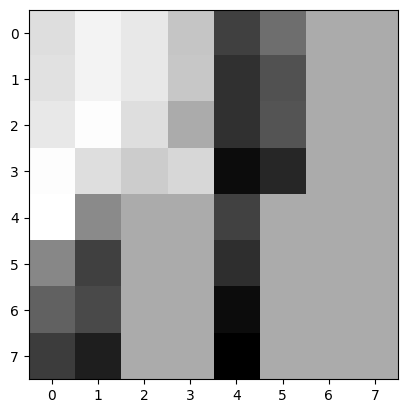

In [13]:
iq = quantize_inverse([block], quantization_table)
print("data after inverse quantization:\n", iq[0])
fig, ax = plt.subplots()
ax.imshow(iq[0], cmap="gray")
plt.show()

## Step 13
### Apply inverse DCT

In [14]:
inverse_dct = block_idct2(iq[0], block_size) + 128

data after inverse dct:
 [[154.93 154.93 160.84 144.64  97.32 108.62 120.67 123.16]
 [156.61 155.41 162.88 148.14  93.12  98.33 117.84 120.3 ]
 [161.57 159.47 157.16 138.8   92.54  97.49 117.28 119.5 ]
 [167.52 142.46 161.55 156.23  81.22  81.94 111.97 114.96]
 [157.75 108.47 147.72 121.54  93.93 123.41 121.59 123.56]
 [105.51  94.76 146.08 118.03  82.73 119.75 116.49 119.39]
 [ 93.65 102.27 145.56 119.65  68.76 119.59 112.98 117.83]
 [ 75.71  90.78 147.42 116.62  63.38 117.28 110.79 115.73]]


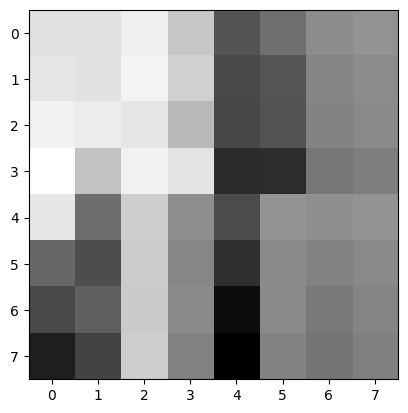

In [15]:
print("data after inverse dct:\n", np.round(inverse_dct,2))

fig, ax = plt.subplots()
ax.imshow(inverse_dct, cmap="gray")
plt.show()

data after inverse dct (rounded to int & clipped to range 0..255):
 [[155. 155. 161. 145.  97. 109. 121. 123.]
 [157. 155. 163. 148.  93.  98. 118. 120.]
 [162. 159. 157. 139.  93.  97. 117. 119.]
 [168. 142. 162. 156.  81.  82. 112. 115.]
 [158. 108. 148. 122.  94. 123. 122. 124.]
 [106.  95. 146. 118.  83. 120. 116. 119.]
 [ 94. 102. 146. 120.  69. 120. 113. 118.]
 [ 76.  91. 147. 117.  63. 117. 111. 116.]]


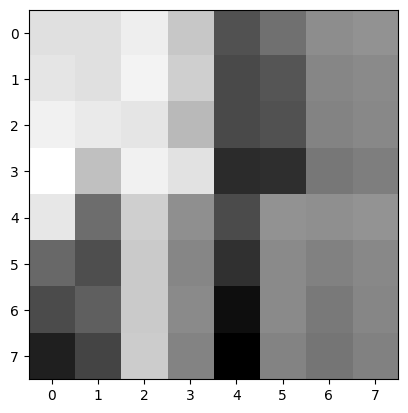

In [16]:
inverse_dct_ints = np.clip(np.rint(inverse_dct), a_min=0, a_max=255)
print("data after inverse dct (rounded to int & clipped to range 0..255):\n", np.round(inverse_dct_ints,2))

fig, ax = plt.subplots()
ax.imshow(inverse_dct_ints, cmap="gray")
plt.show()

original_image:
 [[158 156 165 147  98 106 110 124]
 [157 159 164 144  95 105 108 122]
 [161 163 161 142  94 104 108 121]
 [165 139 161 145  90 101 108 121]
 [152 106 164 142  85 100 105 116]
 [109 105 164 141  87 100 105 117]
 [ 91 105 162 142  86  99 104 116]
 [ 91 103 161 142  83  98 104 122]]


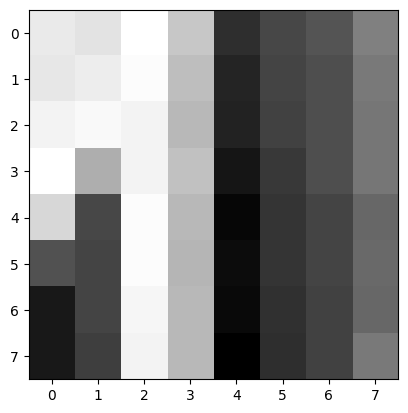

In [17]:
# just for comparison print again
print("original_image:\n",original_image)
fig, ax = plt.subplots()
ax.imshow(original_image, cmap="gray")
plt.show()